# Peter and the Wolf: Reinforcement Learning Primer

In this tutorial, we will learn how to apply Reinforcement learning to a problem of path finding. The setting is inspired by [Peter and the Wolf](https://en.wikipedia.org/wiki/Peter_and_the_Wolf) musical fairy tale by Russian composer [Sergei Prokofiev](https://en.wikipedia.org/wiki/Sergei_Prokofiev). It is a story about young pioneer Peter, who bravely goes out of his house to the forest clearing to chase the wolf. We will train machine learning algorithms that will help Peter to explore the surroinding area and build an optimal navigation map.

First, let's import a bunch of userful libraries:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

## Overview of Reinforcement Learning

**Reinforcement Learning** (RL) is a learning technique that allows us to learn an optimal behaviour of an **agent** in some **environment** by running many experiments. An agent in this environment should have some **goal**, defined by a **reward function**.

## The Environment

For simplicity, let's consider Peter's world to be a square board of size `width` x `height`. Each cell in this board can either be:
* **ground**, on which Peter and other creatures can walk
* **water**, on which you obviously cannot walk
* **a tree** or **grass** - a place where you cat take some rest
* **an apple**, which represents something Peter would be glad to find in order to feed himself
* **a wolf**, which is dangerous and should be avoided

To work with the environment, we will define a class called `Board`. In order not to clutter this notebook too much, we have moved all code to work with the board into separate `rlboard` module, which we will now import. You may look inside this module to get more details about the internals of the implementation.

In [2]:
from rlboard import *

Let's now create a random board and see how it looks:

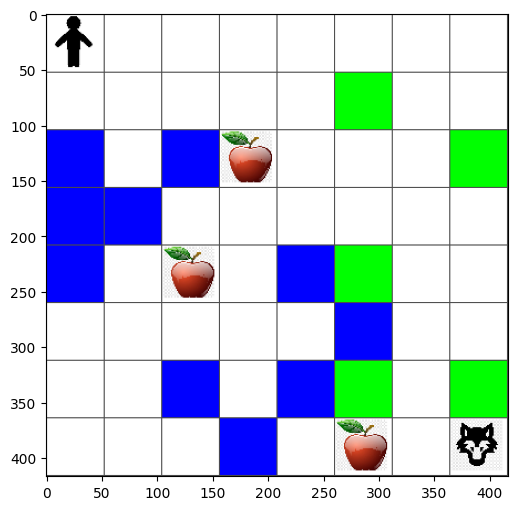

In [5]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

## Actions and Policy

In our example, Peter's goal would be to find an apple, while avoiding the wolf and other obstacles. To do this, he can essentially walk around until he finds and apple. Therefore, at any position he can chose between one of the following actions: up, down, left and right. We will define those actions as a dictionary, and map them to pairs of corresponding coordinate changes. For example, moving right (`R`) would correspond to a pair `(1,0)`.

In [6]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

The strategy of our agent (Peter) is defined by a so-called **policy**. Let's consider the simplest policy called **random walk**.

## Random walk

Let's first solve our problem by implementing a random walk strategy.

In [27]:
def random_policy(m):
    return random.choice(list(actions))

def walk(m,policy,start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position 
    else:
        m.random_start()
    while True:
        if m.at() == Board.Cell.apple:
            return n # success!
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            return -1 # eaten by wolf or drowned
        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human,a)
            if m.is_valid(new_pos) and m.at(new_pos)!=Board.Cell.water:
                # print(new_pos, n) # 不需要调试时注释
                m.move(a) # do the actual move
                break
        n+=1

In [25]:
walk(m,random_policy)

(3, 5) 0
(2, 5) 1
(1, 5) 2
(1, 4) 3
(2, 4) 4


5

Let's run random walk experiment several times and see the average number of steps taken:

In [28]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m, policy)
        if z<0:
            w+=1
        else:
            s += z
            n += 1
    print(f"Average path length = {s/n}, eaten by wolf: {w} times")

print_statistics(random_policy)

Average path length = 29.068181818181817, eaten by wolf: 12 times


## Reward Function

To make our policy more intelligent, we need to understand which moves are "better" than others.



In [29]:
move_reward = -0.1
goal_reward = 10
end_reward = -10

def reward(m,pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x==Board.Cell.water or x == Board.Cell.wolf:
        return end_reward
    if x==Board.Cell.apple:
        return goal_reward
    return move_reward

## Q-Learning

Build a Q-Table, or multi-dimensional array. Since our board has dimensions `width` x `height`, we can represent Q-Table by a numpy array with shape `width` x `height` x `len(actions)`:

In [31]:
Q = np.ones((width,height,len(actions)),dtype=float)*1.0/len(actions)

Pass the Q-Table to the plot function in order to visualize the table on the board:

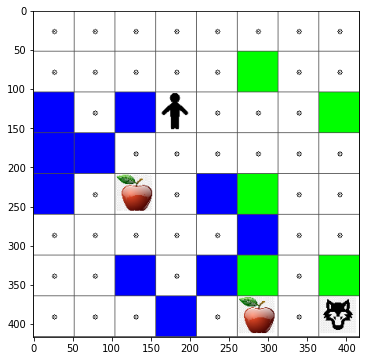

In [9]:
# 在每个单元格的中心有一个"箭头"，表示首选的移动方向。由于所有方向都相等，因此显示一个点。
m.plot(Q)

## Essence of Q-Learning: Bellman Equation and  Learning Algorithm

Write a pseudo-code for our leaning algorithm:

* Initialize Q-Table Q with equal numbers for all states and actions
* Set learning rate $\alpha\leftarrow 1$
* Repeat simulation many times
   1. Start at random position
   1. Repeat
        1. Select an action $a$ at state $s$
        2. Exectute action by moving to a new state $s'$
        3. If we encounter end-of-game condition, or total reward is too small - exit simulation  
        4. Compute reward $r$ at the new state
        5. Update Q-Function according to Bellman equation: $Q(s,a)\leftarrow (1-\alpha)Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a'))$
        6. $s\leftarrow s'$
        7. Update total reward and decrease $\alpha$.

## Exploit vs. Explore

The best approach is to balance between exploration and exploitation. As we learn more about our environment, we would be more likely to follow the optimal route, however, choosing the unexplored path once in a while.

## Python Implementation

Now we are ready to implement the learning algorithm. Before that, we also need some function that will convert arbitrary numbers in the Q-Table into a vector of probabilities for corresponding actions:

In [37]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

We add a small amount of `eps` to the original vector in order to avoid division by 0 in the initial case, when all components of the vector are identical.
The actual learning algorithm we will run for 5000 experiments, also called **epochs**: 

## 学习算法

- 用相同的数字为所有状态和动作初始化 Q-Table Q
- 设置学习率α ← 1
- 多次重复模拟
    i. 随机位置开始
    ii. 重复
        I. 1. 在状态 s 选择一个动作 a 2.通过移动到新状态 s' 来执行动作 3.如果我们遇到游戏结束的情况，或者总奖励太少——退出模拟
        J. 计算新状态下的奖励 r
        K. 根据 Bellman 方程更新 Q-Function： Q(s,a) ← (1-α)Q(s,a)+α(r+γ max(Q( s',a')))
        L. s ← s'
        M. 更新总奖励并减少 α

In [55]:

from IPython.display import clear_output

lpath = []  # 存储每个 epoch 中走的步数

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    m.random_start() # 在每个 epoch 开始时，随机选择起始点
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = m.human
        v = probs(Q[x,y])   # 根据 Q 表中的值计算动作的概率
        a = random.choices(list(actions),weights=v)[0]  # 根据概率选择动作
        dpos = actions[a]
        m.move(dpos,check_correctness=False) # we allow player to move outside the board, which terminates episode
        r = reward(m)
        cum_reward += r
        if r==end_reward or cum_reward < -1000:
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        # Q(s,a) ← (1-α)Q(s,a)+α(r+γ max(Q( s',a')))
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

After executing this algorithm, the Q-Table should be updated with values that define the attractiveness of different actions at each step. Visualize the table here:

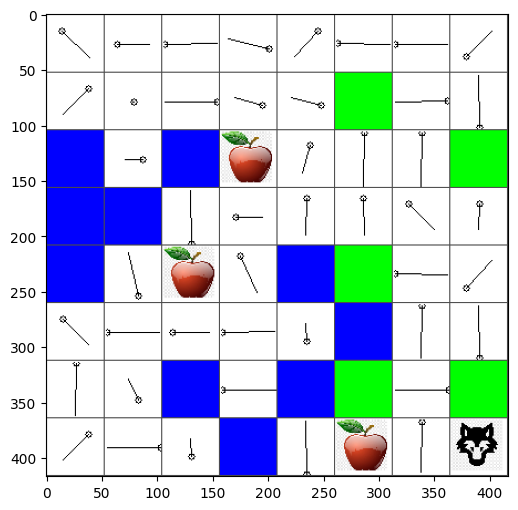

In [39]:
# 在每个单元格上绘制一个向量来可视化 Q-Table，该向量将指向所需的移动方向。
# 为简单起见，我们画一个小圆圈而不是箭头
m.plot(Q)

## Checking the Policy

Since Q-Table lists the "attractiveness" of each action at each state, it is quite easy to use it to define the efficient navigation in our world. In the simplest case, we can just select the action corresponding to the highest Q-Table value:

In [41]:
def qpolicy_strict(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = list(actions)[np.argmax(v)]
        return a

walk(m,qpolicy_strict)

2

If you try the code above several times, you may notice that sometimes it just "hangs", and you need to press the STOP button in the notebook to interrupt it. 
如果你多次尝试上面的代码，你可能会注意到它有时会"挂起"，你需要按笔记本中的 STOP 按钮来中断它。发生这种情况是因为可能存在两种状态在最佳 Q 值方面"指向"彼此的情况，在这种情况下，代理最终会在这些状态之间无限期地移动。

### 挑战
> **Task 1:** Modify the `walk` function to limit the maximum length of path by a certain number of steps (say, 100), and watch the code above return this value from time to time.

> **Task 2:** Modify the `walk` function so that it does not go back to the places where is has already been previously. This will prevent `walk` from looping, however, the agent can still end up being "trapped" in a location from which it is unable to escape. 

In [53]:

def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Average path length = 12.806122448979592, eaten by wolf: 2 times


## Investigating the Learning Process

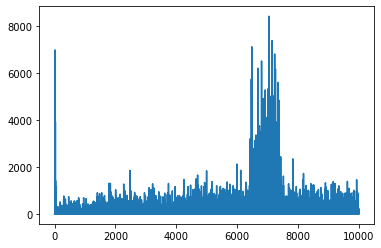

In [15]:
plt.plot(lpath)

# 虽然后面有总结说，前期不好，后面增强学习后变好，但我好像看不出来 

In [45]:
len(lpath)

10000

In [49]:
max(lpath), min(lpath)

(11314, 0)

What we see here is that at first the average path length increased. This is probably due to the fact that when we know nothing about the environment - we are likely to get trapped into bad states, water or wolf. As we learn more and start using this knowledge, we can explore the environment for longer, but we still do not know well where apples are.

Once we learn enough, it becomes easier for the agent to achieve the goal, and the path length starts to decrease. However, we are still open to exploration, so we often diverge away from the best path, and explore new options, making the path longer than optimal.

What we also observe on this graph, is that at some point the length increased abruptly. This indicates stochastic nature of the process, and that we can at some point "sploil" the Q-Table coefficients, by overwriting them with new values. This ideally should be minimized by decreasing learning rate (i.e. towards the end of training we only adjust Q-Table values by a small value).

Overall, it is important to remember that the success and quality of the learning process significantly depends on parameters, such as leaning rate, learning rate decay and discount factor. Those are often called **hyperparameters**, to distinguish them from **parameters** which we optimize during training (eg. Q-Table coefficients). The process of finding best hyperparameter values is called **hyperparameter optimization**, and it deserves a separate topic.

学习内容可以概括为：

平均路径长度增加。我们在这里看到的是，起初，平均路径长度增加。这可能是因为当我们对环境一无所知时，我们很可能会陷入糟糕的状态，水或狼。随着我们学习更多并开始使用这些知识，我们可以更长时间地探索环境，但我们仍然不知道苹果在哪里。

随着我们了解更多，路径长度减少。一旦我们学习得足够多，代理就更容易实现目标，路径长度开始减少。然而，我们仍然对探索持开放态度，因此我们经常偏离最佳路径，并探索新的选择，使路径比最佳路径更长。

长度突然增加。我们在这张图上还观察到，在某个时刻，长度突然增加。这表明该过程的随机性，我们可以在某个时候通过用新值覆盖 Q-Table 系数来"破坏" Q-Table 系数。理想情况下，这应该通过降低学习率来最小化（例如，在训练结束时，我们只调整 Q-Table 很小的一个小值）。

## Exercise
#### A More Realistic Peter and the Wolf World

In our situation, Peter was able to move around almost without getting tired or hungry. In a more realistic world, he has to sit down and rest from time to time, and also to feed himself. Let's make our world more realistic by implementing the following rules:

1. By moving from one place to another, Peter loses **energy** and gains some **fatigue**.
2. Peter can gain more energy by eating apples.
3. Peter can get rid of fatigue by resting under the tree or on the grass (i.e. walking into a board location with a tree or grass - green field)
4. Peter needs to find and kill the wolf
5. In order to kill the wolf, Peter needs to have certain levels of energy and fatigue, otherwise he loses the battle.

Modify the reward function above according to the rules of the game, run the reinforcement learning algorithm to learn the best strategy for winning the game, and compare the results of random walk with your algorithm in terms of number of games won and lost.


> **Note**: You may need to adjust hyperparameters to make it work, especially the number of epochs. Because the success of the game (fighting the wolf) is a rare event, you can expect much longer training time.

